<a href="https://colab.research.google.com/github/NirmalMJohn/DataScience_Project/blob/main/Main_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [319]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [320]:
# Install the tslearn package
!pip install tslearn
import tslearn
print(tslearn.__version__)

0.6.3


In [321]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw

## **Usefull Functions for Analysis**

In [322]:
def merge_imputed_data(tariff_data, missing_data):
    """
    Merges the imputed missing data with the original data and returns the combined DataFrame.

    Parameters:
    tariff_data (pd.DataFrame): The original DataFrame containing the consumption data with potential missing timestamps.
                             It must contain the columns 'LCLid', 'DateTime', and 'Consumption'.
    missing_data (pd.DataFrame): The DataFrame containing the imputed missing data. It must contain the columns
                                 'LCLid', 'MissingDateTime', and 'Consumption' along with 'Hour' and 'Month'.

    Returns:
    pd.DataFrame: A combined DataFrame with the original tariff data and the imputed missing data, sorted by 'LCLid' and 'DateTime'.
    """
    # Append MissingDateTime to original DateTime column in std_data to match the structure
    missing_data['DateTime'] = missing_data['MissingDateTime']
    missing_data = missing_data.drop(columns=['MissingDateTime', 'Hour', 'Month'])

    # Merge the imputed data back to the original std_data
    tariff_data_imputed = pd.concat([tariff_data, missing_data], ignore_index=True)
    tariff_data_imputed = tariff_data_imputed.sort_values(by=['LCLid', 'DateTime']).reset_index(drop=True)

    return tariff_data_imputed

In [323]:
def identify_outliers_iqr(data):
    """
    Identifies outliers in the data based on IQR.

    Parameters:
    - data: DataFrame containing the 'TotalConsumption' column.

    Returns:
    - DataFrame with outliers.
    """
    Q1 = data['TotalConsumption'].quantile(0.25)
    Q3 = data['TotalConsumption'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data['TotalConsumption'] < lower_bound) | (data['TotalConsumption'] > upper_bound)]
    return outliers

def plot_total_consumption_distribution(total_consumption, outliers, title):
    """
    Plots the distribution of total consumption values with outliers
    highlighted as legends.

    Parameters:
    - total_consumption: DataFrame containing LCLid and TotalConsumption
      columns for STD & ToU.
    - outliers: DataFrame containing LCLid and TotalConsumption of the outliers.
    - title: Title for the plot.

    The function uses a boxplot to visualize the distribution and includes legends for outliers
    for easy identification.
    """
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='TotalConsumption', data=total_consumption)

    # Create a color palette for the legends
    unique_outliers = outliers.drop_duplicates(subset=['LCLid'])
    print(f"Unique outliers:\n{unique_outliers}")

    palette = sns.color_palette("hsv", len(unique_outliers))

    # Plot legends for each unique outlier LCLid
    handles = []
    for i in range(unique_outliers.shape[0]):
        handles.append(plt.Line2D([0], [0], marker='o', color='w', label=unique_outliers.iloc[i]['LCLid'],
                                  markerfacecolor=palette[i], markersize=10))

    plt.legend(title='Outlier LCLid', handles=handles)
    plt.title(title)
    plt.xlabel('Total Consumption')
    plt.show()

    return unique_outliers[['LCLid']].reset_index(drop=True)


In [324]:
def plot_monthly_consumption(std_data_clean, tou_data_clean):
    """
    This function plots a line graph comparing the sum of consumption grouped by month
    for the year 2013 from two data frames: std_data_clean and tou_data_clean.

    Parameters:
    std_data_clean (DataFrame): The first data frame containing the standard data.
    tou_data_clean (DataFrame): The second data frame containing the time-of-use data.

    Returns:None
    """
    # Converting DateTime column to datetime type
    std_data_clean['DateTime'] = pd.to_datetime(std_data_clean['DateTime'])
    tou_data_clean['DateTime'] = pd.to_datetime(tou_data_clean['DateTime'])

    # Filtering data for the year 2013
    std_2013 = std_data_clean[std_data_clean['DateTime'].dt.year == 2013]
    tou_2013 = tou_data_clean[tou_data_clean['DateTime'].dt.year == 2013]

    # Grouping by month and summing the Consumption
    std_monthly_consumption = std_2013.groupby(std_2013['DateTime'].dt.month)['Consumption'].sum()
    tou_monthly_consumption = tou_2013.groupby(tou_2013['DateTime'].dt.month)['Consumption'].sum()

    # Plotting the line graph
    plt.figure(figsize=(10, 6))
    plt.plot(std_monthly_consumption.index, std_monthly_consumption.values, label='STD Data', marker='o')
    plt.plot(tou_monthly_consumption.index, tou_monthly_consumption.values, label='TOU Data', marker='o')
    plt.xlabel('Month')
    plt.ylabel('Total Consumption')
    plt.title('Monthly Consumption for Year 2013')
    plt.legend()
    plt.grid(True)
    plt.figtext(0.5, -0.1, 'Figure 1: Comparison of monthly consumption for the year 2013 between STD and TOU data.', ha='center', fontsize=10)
    plt.show()


In [325]:
def normalize_time_series_data(input_df):
    """
    This function normalizes the time-series data (excluding the 'LCLid' and 'DateTime' columns)
    in the provided DataFrame using Min-Max scaling within each group defined by the 'LCLid' column.

    Parameters:
    input_df (pd.DataFrame): DataFrame containing the time-series data with 'LCLid' and 'DateTime' columns.

    Returns:
    pd.DataFrame: DataFrame with normalized time-series data.
    """
    # Group the data by the 'LCLid' column
    groups = input_df.groupby('LCLid')

    # Initialize a list to store the normalized groups
    normalized_groups = []

    # Iterate over each group
    for name, group in groups:
        # Extract time-series columns (excluding the 'LCLid' and 'DateTime' columns)
        time_series_data = group.drop(columns=['LCLid', 'DateTime'])

        # Initialize the scaler
        scaler = MinMaxScaler()

        # Fit and transform the time-series data
        normalized_data = scaler.fit_transform(time_series_data)

        # Create a new DataFrame with the normalized data
        normalized_group = pd.DataFrame(normalized_data, columns=time_series_data.columns)

        # Add the 'LCLid' and 'DateTime' columns back
        normalized_group.insert(0, 'DateTime', group['DateTime'].values)
        normalized_group.insert(0, 'LCLid', group['LCLid'].values)

        # Append the normalized group to the list
        normalized_groups.append(normalized_group)

    # Concatenate all normalized groups into a single DataFrame
    normalized_df = pd.concat(normalized_groups, ignore_index=True)

    return normalized_df

In [326]:
def plot_average_day_comparison(std_df, tou_df, half_hour_intervals=48):
    """
    Plot the average day consumption for STD and ToU datasets, and the percentage difference between them.

    Parameters:
    std_df (pd.DataFrame): DataFrame containing the normalized and pivoted data for the STD dataset.
    tou_df (pd.DataFrame): DataFrame containing the normalized and pivoted data for the ToU dataset.
    half_hour_intervals (int): The number of half-hour intervals to display on the x-axis. Default is 48 (24 hours).
    """
    # Drop the LCLid column to focus on the time series data
    std_data = std_df.drop(columns=['LCLid']).iloc[:, :half_hour_intervals]
    tou_data = tou_df.drop(columns=['LCLid']).iloc[:, :half_hour_intervals]

    # Compute the average consumption for each half-hour interval
    std_mean = std_data.mean(axis=0)
    tou_mean = tou_data.mean(axis=0)

    # Compute the percentage difference
    percent_diff = ((std_mean - tou_mean) / tou_mean) * 100

    # Plotting
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plotting mean consumption
    ax1.plot(std_mean.index, std_mean, color='black', label='STD average day')
    ax1.plot(tou_mean.index, tou_mean, color='orange', label='ToU dataset average day')
    ax1.set_xlabel('Half hour in day (0 = midnight)')
    ax1.set_ylabel('Mean % annual consumption in half hour')
    ax1.legend(loc='upper right')

    # Adding secondary axis for percentage difference
    ax2 = ax1.twinx()
    ax2.bar(std_mean.index, percent_diff, color='grey', alpha=0.5, label='% difference')
    ax2.set_ylabel('% difference between STD and ToU mean value in half hour')

    # Adjusting x-axis limits to the specified period
    ax1.set_xlim([0, half_hour_intervals - 1])

    # Adding a legend
    fig.tight_layout()
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Adding title
    plt.title('STD average day compared with ToU average day')
    plt.show()

In [327]:
def perform_pca(normalized_df, n_components=None):
    """
    Perform PCA on the normalized DataFrame and print explained variance and cumulative explained variance.

    Parameters:
    normalized_df (pd.DataFrame): DataFrame containing normalized time-series data.
    n_components (int or None): Number of PCA components to retain. If None, use min(n_samples, n_features).

    Returns:
    pd.DataFrame: PCA-transformed data as a DataFrame.
    """
    # Extract time-series data and identifiers
    identifiers = normalized_df.iloc[:, 0].values
    time_series_data = normalized_df.iloc[:, 1:].values

    # Standardize the data
    scaler = StandardScaler()
    time_series_data_scaled = scaler.fit_transform(time_series_data)

    # Determine the number of PCA components to use
    n_samples, n_features = time_series_data_scaled.shape
    if n_components is None:
        n_components = min(n_samples, n_features)

    # Ensure n_components is not greater than the number of features
    n_components = min(n_components, n_features)

    # Apply PCA
    pca = PCA(n_components=n_components)
    time_series_data_pca = pca.fit_transform(time_series_data_scaled)

    # Print explained variance and cumulative explained variance
    explained_variance = pca.explained_variance_ratio_
    cumulative_explained_variance = explained_variance.cumsum()
    print("Explained Variance by each component:", explained_variance)
    print("Cumulative Explained Variance:", cumulative_explained_variance)

    # Convert PCA-transformed data back to DataFrame
    pca_df = pd.DataFrame(time_series_data_pca, columns=[f'PC{i+1}' for i in range(n_components)])
    pca_df.insert(0, normalized_df.columns[0], identifiers)

    return pca_df

In [382]:
def find_optimal_clusters_pca(pca_df, max_clusters=10):
    """
    Find the optimal number of clusters for PCA-transformed data using the elbow method and silhouette score.

    Parameters:
    pca_df (pd.DataFrame): PCA-transformed data.
    max_clusters (int): Maximum number of clusters to test.

    Returns:
    None
    """
    data = pca_df.iloc[:, 1:].values
    num_clusters = range(2, max_clusters + 1)
    sum_of_squared_distances = []
    silhouette_scores = []

    for k in num_clusters:
        model = TimeSeriesKMeans(n_clusters=k, metric="dtw", verbose=True, random_state=42)
        cluster_labels = model.fit_predict(data)

        sum_of_squared_distances.append(model.inertia_)
        silhouette_avg = silhouette_score(data, cluster_labels, metric=dtw)
        silhouette_scores.append(silhouette_avg)

    # Plot the elbow method
    plt.figure(figsize=(12, 6))
    plt.plot(num_clusters, sum_of_squared_distances, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Sum of squared distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

    # Plot the silhouette scores
    plt.figure(figsize=(12, 6))
    plt.plot(num_clusters, silhouette_scores, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Silhouette Score For Optimal k')
    plt.show()

    optimal_clusters = num_clusters[np.argmax(silhouette_scores)]
    print(f'Optimal number of clusters: {optimal_clusters}')

In [384]:
def perform_clustering(pca_df, n_clusters):
    """
    Perform clustering on the PCA-transformed time series data.

    Parameters:
    pca_df (pd.DataFrame): PCA-transformed data.
    n_clusters (int): Number of clusters.

    Returns:
    pd.DataFrame: DataFrame with cluster labels.
    """
    data = pca_df.iloc[:, 1:].values
    model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", verbose=True, random_state=42)
    cluster_labels = model.fit_predict(data)

    pca_df_with_labels = pca_df.copy()
    pca_df_with_labels['Cluster'] = cluster_labels
    return pca_df_with_labels


In [386]:
def plot_clusters(pca_df_with_labels, title):
    """
    Plot the clusters formed by K-Means clustering with DTW using a scatter plot of the first two PCA components.

    Parameters:
    pca_df_with_labels (pd.DataFrame): PCA-transformed data with cluster labels.
    title (str): Title of the plot.
    """
    cluster_labels = pca_df_with_labels['Cluster'].values
    unique_clusters = np.unique(cluster_labels)

    plt.figure(figsize=(15, 10))

    # Plot each cluster separately
    for cluster in unique_clusters:
        cluster_data = pca_df_with_labels[pca_df_with_labels['Cluster'] == cluster]
        plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}')

    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

In [390]:
def plot_cluster_daily_consumption(df, half_hour_intervals=48):
    """
    Plot the summed consumption over 24 hours (48 half-hour intervals) for each cluster.

    Parameters:
    df (pd.DataFrame): DataFrame containing the time-series data  for STD
    with a 'Cluster' column.
    half_hour_intervals (int): The number of half-hour intervals to display on
    the x-axis. Default is 48 (24 hours).
    """
    # Ensure the DataFrame is limited to the required half-hour intervals and clusters
    consumption_data = df.drop(columns=['LCLid', 'Cluster']).iloc[:, :half_hour_intervals]
    clusters = df['Cluster']

    # Sum the consumption values for each cluster
    cluster_sums = consumption_data.groupby(clusters).sum()

    # Plotting
    plt.figure(figsize=(14, 7))
    for cluster_id, row in cluster_sums.iterrows():
        plt.plot(range(half_hour_intervals), row, label=f'Cluster {cluster_id}')

    plt.xlabel('Half hour in day (0 = midnight)')
    plt.ylabel('Sum of annual consumption in half hour')
    plt.title('Aggregated  Consumption over 24 Hours for Each Cluster')
    plt.legend()
    plt.show()


## **Sampling Data taking 50 unique LCLid of customers in STD and ToU Tariff from Year 2013**

In [332]:
import pandas as pd

filename = '/content/drive/MyDrive/LCL-FullData/CC_LCL-FullData.csv'
chunksize = 10**6  # Adjust based on available memory

# Desired date range
start_date = pd.to_datetime('2013-01-01')
end_date = pd.to_datetime('2014-02-28')

# Step 1: Identify IDs with complete date coverage
std_ids = set()
tou_ids = set()

# Read file in chunks
for chunk in pd.read_csv(filename, chunksize=chunksize, parse_dates=['DateTime']):
    # Ensure DateTime column is properly parsed
    chunk['DateTime'] = pd.to_datetime(chunk['DateTime'], errors='coerce')

    # Filter by date range first
    chunk = chunk[(chunk['DateTime'] >= start_date) & (chunk['DateTime'] <= end_date)]

    if len(std_ids) < 50:
        std_chunk = chunk[chunk['stdorToU'] == 'Std']
        grouped_std = std_chunk.groupby('LCLid')
        for name, group in grouped_std:
            if group['DateTime'].min() <= start_date and group['DateTime'].max() >= end_date:
                std_ids.add(name)
            if len(std_ids) >= 50:
                break

    if len(tou_ids) < 50:
        tou_chunk = chunk[chunk['stdorToU'] == 'ToU']
        grouped_tou = tou_chunk.groupby('LCLid')
        for name, group in grouped_tou:
            if group['DateTime'].min() <= start_date and group['DateTime'].max() >= end_date:
                tou_ids.add(name)
            if len(tou_ids) >= 50:
                break

    # Check if we have enough IDs
    if len(std_ids) >= 50 and len(tou_ids) >= 50:
        break

std_ids = list(std_ids)
tou_ids = list(tou_ids)

# Debug: Check if the correct IDs were identified
print(f"STD IDs (count: {len(std_ids)}): {std_ids[:5]}")  # Print first 5 IDs for verification
print(f"TOU IDs (count: {len(tou_ids)}): {tou_ids[:5]}")  # Print first 5 IDs for verification

# Step 2: Collect all rows for selected IDs
std_data = []
tou_data = []

for chunk in pd.read_csv(filename, chunksize=chunksize, parse_dates=['DateTime']):
    chunk['DateTime'] = pd.to_datetime(chunk['DateTime'], errors='coerce')

    std_chunk = chunk[chunk['LCLid'].isin(std_ids) & (chunk['stdorToU'] == 'Std')]
    tou_chunk = chunk[chunk['LCLid'].isin(tou_ids) & (chunk['stdorToU'] == 'ToU')]

    std_data.append(std_chunk)
    tou_data.append(tou_chunk)

# Concatenate the dataframes only if they are not empty
if std_data:
    std_data = pd.concat(std_data)
else:
    std_data = pd.DataFrame()

if tou_data:
    tou_data = pd.concat(tou_data)
else:
    tou_data = pd.DataFrame()

# Filter concatenated data by date range to ensure correctness
std_data = std_data[(std_data['DateTime'] >= start_date) & (std_data['DateTime'] <= end_date)]
tou_data = tou_data[(tou_data['DateTime'] >= start_date) & (tou_data['DateTime'] <= end_date)]

# Debug: Check the range of dates in the resulting data
print("STD Data Date Range:", std_data['DateTime'].min(), "-", std_data['DateTime'].max())
print("TOU Data Date Range:", tou_data['DateTime'].min(), "-", tou_data['DateTime'].max())

print("STD Data:")
print(std_data.head())
print("\nTOU Data:")
print(tou_data.head())

STD IDs (count: 50): ['MAC000032', 'MAC000047', 'MAC000012', 'MAC000066', 'MAC000041']
TOU IDs (count: 50): ['MAC000344', 'MAC000292', 'MAC000015', 'MAC000051', 'MAC000195']
STD Data Date Range: 2013-01-01 00:00:00 - 2014-02-28 00:00:00
TOU Data Date Range: 2013-01-01 00:00:00 - 2014-02-28 00:00:00
STD Data:
          LCLid stdorToU            DateTime KWH/hh (per half hour) 
3840  MAC000002      Std 2013-01-01 00:00:00                  0.219 
3841  MAC000002      Std 2013-01-01 00:30:00                  0.241 
3842  MAC000002      Std 2013-01-01 01:00:00                  0.191 
3843  MAC000002      Std 2013-01-01 01:30:00                  0.235 
3844  MAC000002      Std 2013-01-01 02:00:00                  0.182 

TOU Data:
               LCLid stdorToU            DateTime KWH/hh (per half hour) 
134158912  MAC000005      ToU 2013-01-01 00:00:00                  0.096 
134158913  MAC000005      ToU 2013-01-01 00:30:00                  0.111 
134158914  MAC000005      ToU 2013-01-01 01

#**Preprocessing**

In [333]:
# Renaming the Column name KWH/hh (per half hour) to Consumption in std Data
std_data.rename(columns={'KWH/hh (per half hour) ': 'Consumption'}, inplace=True)
tou_data.rename(columns={'KWH/hh (per half hour) ': 'Consumption'}, inplace=True)

<ipython-input-333-f0d79ed1ce01>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  std_data.rename(columns={'KWH/hh (per half hour) ': 'Consumption'}, inplace=True)


In [334]:
# Droping Column stdorTou from both Std & ToU dataframes
std_data.drop('stdorToU', axis=1, inplace=True)
tou_data.drop('stdorToU', axis=1, inplace=True)

In [335]:
# Resetting the Index of Dataframes
std_data = std_data.reset_index(drop=True)
tou_data = tou_data.reset_index(drop=True)


In [336]:
std_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015780 entries, 0 to 1015779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   LCLid        1015780 non-null  object        
 1   DateTime     1015780 non-null  datetime64[ns]
 2   Consumption  1015780 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 23.2+ MB


In [337]:
nan_count = std_data.isna().sum()
print(f"Number of NaN values: {nan_count}")


Number of NaN values: LCLid          0
DateTime       0
Consumption    0
dtype: int64


In [338]:
std_data.columns

Index(['LCLid', 'DateTime', 'Consumption'], dtype='object')

In [339]:
tou_data.columns

Index(['LCLid', 'DateTime', 'Consumption'], dtype='object')

In [340]:
#Parsing the DateTime column in both data frames
std_data['DateTime'] = pd.to_datetime(std_data['DateTime'])
tou_data['DateTime'] = pd.to_datetime(tou_data['DateTime'])

## **Missing Value Imputation for STD Data**

In [341]:
std_data['DateTime'] = pd.to_datetime(std_data['DateTime'])  # Convert to datetime if not already
std_data['Consumption'] = pd.to_numeric(std_data['Consumption'], errors='coerce')  # Ensure numeric

# Find complete DateTime range
min_date = std_data['DateTime'].min()
max_date = std_data['DateTime'].max()
freq = '30min'  # Frequency of 30 minutes

all_dates = pd.date_range(start=min_date, end=max_date, freq=freq)

In [342]:
# Initialize an empty DataFrame to store missing data and a list to store missing counts
missing_data = pd.DataFrame()
missing_counts = []

# Identify missing DateTime values for each LCLid and count missing days
for lid, group in std_data.groupby('LCLid'):
    existing_dates = pd.to_datetime(group['DateTime'])
    missing_dates = pd.Series(all_dates.difference(existing_dates))  # Convert to Pandas Series

    if not missing_dates.empty:
        # Count unique missing days
        missing_days_count = missing_dates.dt.date.nunique()
        missing_counts.append({'LCLid': lid, 'MissingDaysCount': missing_days_count})

        # Create a DataFrame for the missing rows
        missing_rows = pd.DataFrame({
            'LCLid': lid,
            'MissingDateTime': missing_dates
        })
        missing_data = pd.concat([missing_data, missing_rows], ignore_index=True)

# Convert missing counts to a DataFrame
missing_counts_df = pd.DataFrame(missing_counts)

# Print the missing counts DataFrame
print(missing_counts_df)

# Print a sample of the missing data DataFrame
print(missing_data.head())


        LCLid  MissingDaysCount
0   MAC000002                 1
1   MAC000003                 2
2   MAC000004                 1
3   MAC000007                 5
4   MAC000009                 1
5   MAC000011                 1
6   MAC000012                 2
7   MAC000013                 1
8   MAC000020                 2
9   MAC000021                 1
10  MAC000022                 2
11  MAC000023                 1
12  MAC000024                 1
13  MAC000025                 6
14  MAC000026                 5
15  MAC000027                 2
16  MAC000029                 1
17  MAC000030                 3
18  MAC000032                 1
19  MAC000033                 2
20  MAC000034                 2
21  MAC000035                 2
22  MAC000036                 1
23  MAC000037                 1
24  MAC000038                 3
25  MAC000039                 2
26  MAC000041                 2
27  MAC000042                 2
28  MAC000043                 2
29  MAC000045                 2
30  MAC0

In [343]:
# Extract Hour and Month from MissingDateTime
missing_data['MissingDateTime'] = pd.to_datetime(missing_data['MissingDateTime'])
missing_data['Hour'] = missing_data['MissingDateTime'].dt.hour
missing_data['Month'] = missing_data['MissingDateTime'].dt.month

# Extract Hour and Month from DateTime in original std_data
std_data['Hour'] = std_data['DateTime'].dt.hour
std_data['Month'] = std_data['DateTime'].dt.month

# Calculate the average consumption for each LCLid, Month, and Hour
avg_consumption = std_data.groupby(['LCLid', 'Month', 'Hour'])['Consumption'].mean().reset_index()
avg_consumption.rename(columns={'Consumption': 'AvgConsumption'}, inplace=True)

In [344]:
# Merge missing_data with avg_consumption to get the imputed values
missing_data = pd.merge(missing_data, avg_consumption, how='left', on=['LCLid', 'Month', 'Hour'])

# Rename the AvgConsumption column to Consumption to match original std_data structure
missing_data.rename(columns={'AvgConsumption': 'Consumption'}, inplace=True)

In [345]:
# Check for any remaining missing values
remaining_missing = missing_data[missing_data['Consumption'].isnull()]

if remaining_missing.empty:
    print("No missing values remain after imputation.")
else:
    print("There are still missing values after imputation:")
    print(remaining_missing)

No missing values remain after imputation.


In [346]:
# Call the function and get the imputed DataFrame
std_data_imputed = merge_imputed_data(std_data, missing_data)
print(std_data_imputed)

             LCLid            DateTime  Consumption  Hour  Month
0        MAC000002 2013-01-01 00:00:00        0.219   0.0    1.0
1        MAC000002 2013-01-01 00:30:00        0.241   0.0    1.0
2        MAC000002 2013-01-01 01:00:00        0.191   1.0    1.0
3        MAC000002 2013-01-01 01:30:00        0.235   1.0    1.0
4        MAC000002 2013-01-01 02:00:00        0.182   2.0    1.0
...            ...                 ...          ...   ...    ...
1015945  MAC000068 2014-02-27 22:30:00        0.924  22.0    2.0
1015946  MAC000068 2014-02-27 23:00:00        0.876  23.0    2.0
1015947  MAC000068 2014-02-27 23:30:00        0.306  23.0    2.0
1015948  MAC000068 2014-02-28 00:00:00        0.253   0.0    2.0
1015949  MAC000068 2014-02-28 00:00:00        0.253   0.0    2.0

[1015950 rows x 5 columns]


In [347]:
std_data_imputed.columns

Index(['LCLid', 'DateTime', 'Consumption', 'Hour', 'Month'], dtype='object')



## **Missing Value imputation for ToU Data**



In [348]:
tou_data['DateTime'] = pd.to_datetime(tou_data['DateTime'])  # Convert to datetime if not already
tou_data['Consumption'] = pd.to_numeric(tou_data['Consumption'], errors='coerce')  # Ensure numeric

# Find complete DateTime range
min_date = tou_data['DateTime'].min()
max_date = tou_data['DateTime'].max()
freq = '30min'  # Frequency of 30 minutes

all_dates = pd.date_range(start=min_date, end=max_date, freq=freq)

In [349]:
# Initialize an empty DataFrame to store missing data and a list to store missing counts
missing_data = pd.DataFrame()
missing_counts = []

# Identify missing DateTime values for each LCLid and count missing days
for lid, group in tou_data.groupby('LCLid'):
    existing_dates = pd.to_datetime(group['DateTime'])
    missing_dates = pd.Series(all_dates.difference(existing_dates))  # Convert to Pandas Series

    if not missing_dates.empty:
        # Count unique missing days
        missing_days_count = missing_dates.dt.date.nunique()
        missing_counts.append({'LCLid': lid, 'MissingDaysCount': missing_days_count})

        # Create a DataFrame for the missing rows
        missing_rows = pd.DataFrame({
            'LCLid': lid,
            'MissingDateTime': missing_dates
        })
        missing_data = pd.concat([missing_data, missing_rows], ignore_index=True)

# Convert missing counts to a DataFrame
missing_counts_df = pd.DataFrame(missing_counts)

# Print the missing counts DataFrame
print(missing_counts_df)

# Print a sample of the missing data DataFrame
print(missing_data.head())


        LCLid  MissingDaysCount
0   MAC000005                 1
1   MAC000014                 7
2   MAC000015                11
3   MAC000017                 2
4   MAC000031                 4
5   MAC000044                 1
6   MAC000046                 1
7   MAC000051                 8
8   MAC000052                 2
9   MAC000064                 1
10  MAC000075                 1
11  MAC000076                 5
12  MAC000082                 1
13  MAC000088                 1
14  MAC000107                 1
15  MAC000109                 2
16  MAC000124                 4
17  MAC000141                 1
18  MAC000158                 6
19  MAC000170                 5
20  MAC000173                 5
21  MAC000186                 5
22  MAC000194                 6
23  MAC000195                 2
24  MAC000198                 1
25  MAC000219                 5
26  MAC000236                 4
27  MAC000247                 4
28  MAC000257                 3
29  MAC000259                 6
30  MAC0

In [350]:
# Extract Hour and Month from MissingDateTime
missing_data['MissingDateTime'] = pd.to_datetime(missing_data['MissingDateTime'])
missing_data['Hour'] = missing_data['MissingDateTime'].dt.hour
missing_data['Month'] = missing_data['MissingDateTime'].dt.month

# Extract Hour and Month from DateTime in original std_data
tou_data['Hour'] = std_data['DateTime'].dt.hour
tou_data['Month'] = std_data['DateTime'].dt.month

# Calculate the average consumption for each LCLid, Month, and Hour
avg_consumption = tou_data.groupby(['LCLid', 'Month', 'Hour'])['Consumption'].mean().reset_index()
avg_consumption.rename(columns={'Consumption': 'AvgConsumption'}, inplace=True)

In [351]:
# Merge missing_data with avg_consumption to get the imputed values
missing_data = pd.merge(missing_data, avg_consumption, how='left', on=['LCLid', 'Month', 'Hour'])

# Rename the AvgConsumption column to Consumption to match original std_data structure
missing_data.rename(columns={'AvgConsumption': 'Consumption'}, inplace=True)

In [352]:
# Check for any remaining missing values
remaining_missing = missing_data[missing_data['Consumption'].isnull()]

if remaining_missing.empty:
    print("No missing values remain after imputation.")
else:
    print("There are still missing values after imputation:")
    print(remaining_missing)

No missing values remain after imputation.


In [353]:
# Call the function and get the imputed DataFrame
tou_data_imputed = merge_imputed_data(tou_data, missing_data)
print(tou_data_imputed)

             LCLid            DateTime  Consumption  Hour  Month
0        MAC000005 2013-01-01 00:00:00        0.096   0.0    1.0
1        MAC000005 2013-01-01 00:30:00        0.111   0.0    1.0
2        MAC000005 2013-01-01 01:00:00        0.071   1.0    1.0
3        MAC000005 2013-01-01 01:30:00        0.035   1.0    1.0
4        MAC000005 2013-01-01 02:00:00        0.035   2.0    1.0
...            ...                 ...          ...   ...    ...
1015945  MAC000344 2014-02-27 22:30:00        0.188  10.0    2.0
1015946  MAC000344 2014-02-27 23:00:00        0.142  10.0    2.0
1015947  MAC000344 2014-02-27 23:30:00        0.125  11.0    2.0
1015948  MAC000344 2014-02-28 00:00:00        0.151  11.0    2.0
1015949  MAC000344 2014-02-28 00:00:00        0.151  12.0    2.0

[1015950 rows x 5 columns]


### **Show a Missing data series graph if necessary**

## **Checking for Start and End Datetime for both STD & ToU data**

In [354]:
# Group by LCLid and find the minimum and maximum DateTime for each LCLid for STD imputed data
std_startend_datetime = std_data_imputed.groupby('LCLid')['DateTime'].agg(['min', 'max']).reset_index()

# Rename the columns for better readability
std_startend_datetime.columns = ['LCLid', 'StartDateTime', 'EndDateTime']

# Ensure that the time component is included in the display
std_startend_datetime['StartDateTime'] = std_startend_datetime['StartDateTime'].dt.strftime('%Y-%m-%d %H:%M:%S')
std_startend_datetime['EndDateTime'] = std_startend_datetime['EndDateTime'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Print the start and end DateTime for each LCLid
print(std_startend_datetime)

        LCLid        StartDateTime          EndDateTime
0   MAC000002  2013-01-01 00:00:00  2014-02-28 00:00:00
1   MAC000003  2013-01-01 00:00:00  2014-02-28 00:00:00
2   MAC000004  2013-01-01 00:00:00  2014-02-28 00:00:00
3   MAC000006  2013-01-01 00:00:00  2014-02-28 00:00:00
4   MAC000007  2013-01-01 00:00:00  2014-02-28 00:00:00
5   MAC000009  2013-01-01 00:00:00  2014-02-28 00:00:00
6   MAC000010  2013-01-01 00:00:00  2014-02-28 00:00:00
7   MAC000011  2013-01-01 00:00:00  2014-02-28 00:00:00
8   MAC000012  2013-01-01 00:00:00  2014-02-28 00:00:00
9   MAC000013  2013-01-01 00:00:00  2014-02-28 00:00:00
10  MAC000018  2013-01-01 00:00:00  2014-02-28 00:00:00
11  MAC000019  2013-01-01 00:00:00  2014-02-28 00:00:00
12  MAC000020  2013-01-01 00:00:00  2014-02-28 00:00:00
13  MAC000021  2013-01-01 00:00:00  2014-02-28 00:00:00
14  MAC000022  2013-01-01 00:00:00  2014-02-28 00:00:00
15  MAC000023  2013-01-01 00:00:00  2014-02-28 00:00:00
16  MAC000024  2013-01-01 00:00:00  2014-02-28 0

In [355]:
# Group by LCLid and find the minimum and maximum DateTime for each LCLid for ToU imputed data
tou_startend_datetime = tou_data_imputed.groupby('LCLid')['DateTime'].agg(['min', 'max']).reset_index()

# Rename the columns for better readability
tou_startend_datetime.columns = ['LCLid', 'StartDateTime', 'EndDateTime']

# Ensure that the time component is included in the display
tou_startend_datetime['StartDateTime'] = tou_startend_datetime['StartDateTime'].dt.strftime('%Y-%m-%d %H:%M:%S')
tou_startend_datetime['EndDateTime'] = tou_startend_datetime['EndDateTime'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Print the start and end DateTime for each LCLid
print(tou_startend_datetime)

        LCLid        StartDateTime          EndDateTime
0   MAC000005  2013-01-01 00:00:00  2014-02-28 00:00:00
1   MAC000014  2013-01-01 00:00:00  2014-02-28 00:00:00
2   MAC000015  2013-01-01 00:00:00  2014-02-28 00:00:00
3   MAC000017  2013-01-01 00:00:00  2014-02-28 00:00:00
4   MAC000031  2013-01-01 00:00:00  2014-02-28 00:00:00
5   MAC000044  2013-01-01 00:00:00  2014-02-28 00:00:00
6   MAC000046  2013-01-01 00:00:00  2014-02-28 00:00:00
7   MAC000048  2013-01-01 00:00:00  2014-02-28 00:00:00
8   MAC000051  2013-01-01 00:00:00  2014-02-28 00:00:00
9   MAC000052  2013-01-01 00:00:00  2014-02-28 00:00:00
10  MAC000064  2013-01-01 00:00:00  2014-02-28 00:00:00
11  MAC000075  2013-01-01 00:00:00  2014-02-28 00:00:00
12  MAC000076  2013-01-01 00:00:00  2014-02-28 00:00:00
13  MAC000082  2013-01-01 00:00:00  2014-02-28 00:00:00
14  MAC000088  2013-01-01 00:00:00  2014-02-28 00:00:00
15  MAC000106  2013-01-01 00:00:00  2014-02-28 00:00:00
16  MAC000107  2013-01-01 00:00:00  2014-02-28 0

### **Table shows that we dont have the whole 48 hr record for 28-02-2014 Hence it needs to omitted from the respective data frame.**

In [356]:
# Removing the Rows where Datetime is 28-02-2014
std_data_imputed = std_data_imputed[std_data_imputed['DateTime'] != '2014-02-28']
tou_data_imputed = tou_data_imputed[tou_data_imputed['DateTime'] != '2014-02-28']

In [357]:
std_data_imputed.columns

Index(['LCLid', 'DateTime', 'Consumption', 'Hour', 'Month'], dtype='object')

##**Checking for Outliers**

In [358]:
std_total = std_data_imputed.groupby('LCLid')['Consumption'].sum().reset_index()
tou_total = tou_data_imputed.groupby('LCLid')['Consumption'].sum().reset_index()

In [359]:
std_total.columns = ['LCLid', 'TotalConsumption']
tou_total.columns = ['LCLid', 'TotalConsumption']

Unique outliers:
        LCLid  TotalConsumption
6   MAC000010      11000.233997
24  MAC000034      11933.799486
30  MAC000040      13429.052001
36  MAC000049      14920.786002


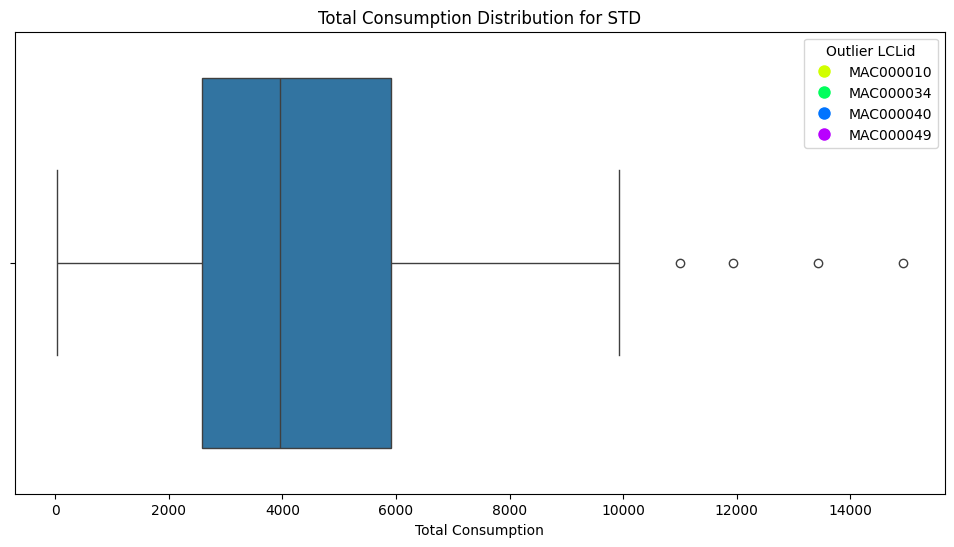

Unique outliers:
        LCLid  TotalConsumption
34  MAC000257      11525.505647


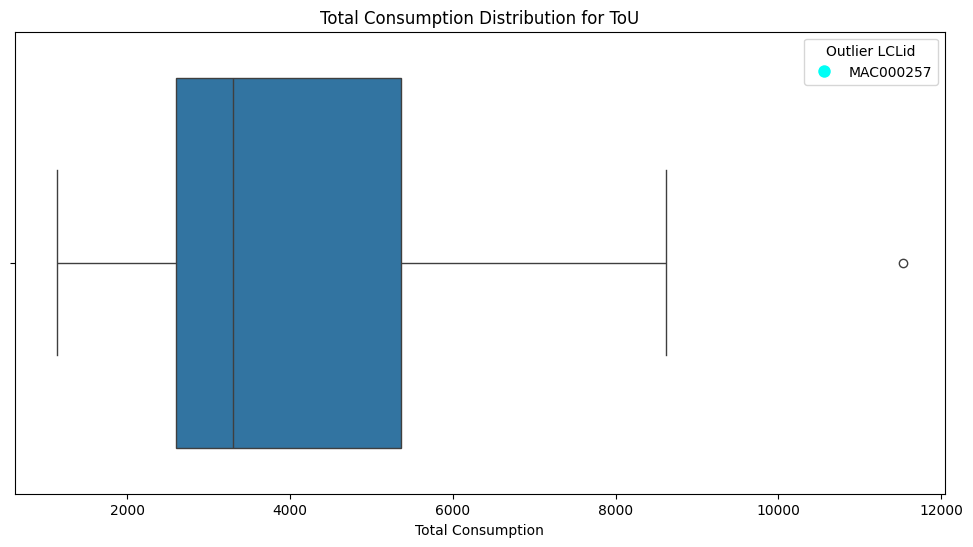

In [360]:
# Identify outliers for STD using the IQR method
std_outliers = identify_outliers_iqr(std_total)

# Identify outliers for ToU using the IQR method
tou_outliers = identify_outliers_iqr(tou_total)

# Plot the example distribution with a custom title
std_outlier_lclid = plot_total_consumption_distribution(std_total, std_outliers, 'Total Consumption Distribution for STD')

# Plot the example distribution with a custom title
tou_outlier_lclid = plot_total_consumption_distribution(tou_total, tou_outliers, 'Total Consumption Distribution for ToU')


###**Plot the Graphs for Outliers present in STD & ToU**

## **Loading Weather Data**

In [361]:
weather_data = pd.read_csv('/content/drive/MyDrive/open-meteo-51.49N0.16W23m (1).csv', skiprows=3)

In [362]:
weather_data.head()

,time,temperature_2m (°C)
0,2010-01-01T00:00,0.4
1,2010-01-01T01:00,0.3
2,2010-01-01T02:00,0.1
3,2010-01-01T03:00,-0.2
4,2010-01-01T04:00,-0.4


In [363]:
# Convert 'time' column to datetime objects, coerce errors to handle inconsistencies
weather_data['time'] = pd.to_datetime(weather_data['time'], errors='coerce')

# Drop rows with NaT in 'time' column (result of conversion errors)
weather_data = weather_data.dropna(subset=['time'])

# Filter the DataFrame for the specified date range
start_date = "2013-01-01"
end_date = "2014-02-28"
mask = (weather_data['time'] >= start_date) & (weather_data['time'] <= end_date)
filtered_weather_data = weather_data.loc[mask]
filtered_weather_data.reset_index(drop=True, inplace=True)

# Display the filtered DataFrame
# Format the 'time' column to the desired format without the "T"
filtered_weather_data['time'] = filtered_weather_data['time'].dt.strftime("%Y-%m-%d %H:%M")

# Display the filtered and formatted DataFrame
print(filtered_weather_data.head())


               time temperature_2m (°C)
0  2013-01-01 00:00                 8.6
1  2013-01-01 01:00                 8.3
2  2013-01-01 02:00                 7.5
3  2013-01-01 03:00                 6.8
4  2013-01-01 04:00                 5.9


<ipython-input-363-48dcf8a3d51b>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_weather_data['time'] = filtered_weather_data['time'].dt.strftime("%Y-%m-%d %H:%M")


In [364]:
filtered_weather_data.to_csv('filtered_weather_data.csv')

# **EDA**

In [365]:
std_data_clean = std_data_imputed.copy()

In [366]:
std_data_clean

,LCLid,DateTime,Consumption,Hour,Month
0,MAC000002,2013-01-01 00:00:00,0.219,0.0,1.0
1,MAC000002,2013-01-01 00:30:00,0.241,0.0,1.0
2,MAC000002,2013-01-01 01:00:00,0.191,1.0,1.0
3,MAC000002,2013-01-01 01:30:00,0.235,1.0,1.0
4,MAC000002,2013-01-01 02:00:00,0.182,2.0,1.0
...,...,...,...,...,...
1015943,MAC000068,2014-02-27 21:30:00,0.458,21.0,2.0
1015944,MAC000068,2014-02-27 22:00:00,0.538,22.0,2.0
1015945,MAC000068,2014-02-27 22:30:00,0.924,22.0,2.0
1015946,MAC000068,2014-02-27 23:00:00,0.876,23.0,2.0


In [367]:
std_data_clean.columns

Index(['LCLid', 'DateTime', 'Consumption', 'Hour', 'Month'], dtype='object')

In [368]:
tou_data_clean = tou_data_imputed.copy()

## **Plotting a Total Monthly Consumption Graph for both STD & ToU**

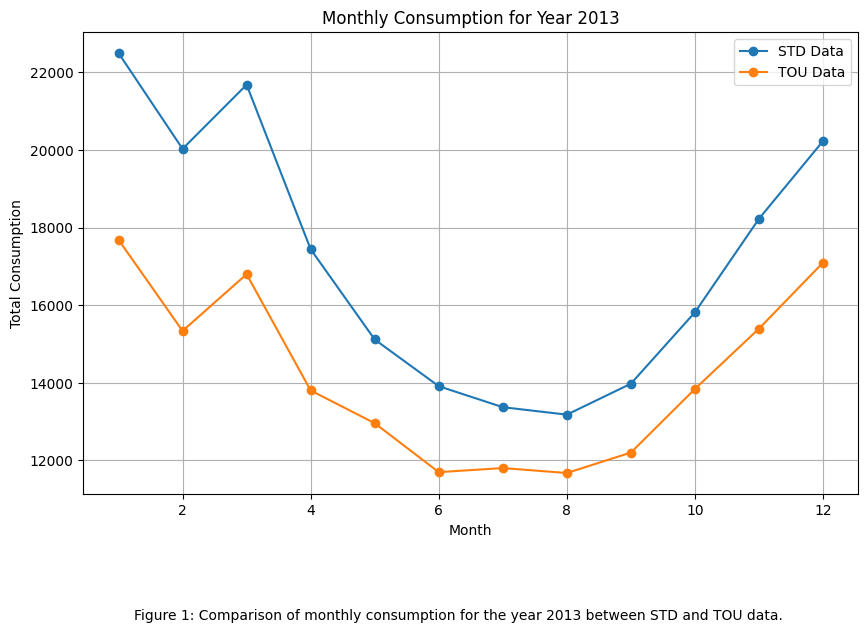

In [369]:
# Calling the function
plot_monthly_consumption(std_data_clean, tou_data_clean)

## Observation: From this line plot it is evident that the Consumers under ToU are having less consumption compared to STD Consumers

In [370]:
# Drop columns 'Hour' and 'Month'
std_data_clean = std_data_clean.drop(columns=['Hour', 'Month'])
tou_data_clean = tou_data_clean.drop(columns=['Hour', 'Month'])

In [371]:
std_data_clean.columns

Index(['LCLid', 'DateTime', 'Consumption'], dtype='object')

In [372]:
tou_data_clean.columns

Index(['LCLid', 'DateTime', 'Consumption'], dtype='object')

In [373]:
std_data_clean

,LCLid,DateTime,Consumption
0,MAC000002,2013-01-01 00:00:00,0.219
1,MAC000002,2013-01-01 00:30:00,0.241
2,MAC000002,2013-01-01 01:00:00,0.191
3,MAC000002,2013-01-01 01:30:00,0.235
4,MAC000002,2013-01-01 02:00:00,0.182
...,...,...,...
1015943,MAC000068,2014-02-27 21:30:00,0.458
1015944,MAC000068,2014-02-27 22:00:00,0.538
1015945,MAC000068,2014-02-27 22:30:00,0.924
1015946,MAC000068,2014-02-27 23:00:00,0.876


## **Normalization**

In [374]:
normalized_std_df = normalize_time_series_data(std_data_clean)
normalized_tou_df = normalize_time_series_data(tou_data_clean)

In [375]:
normalized_std_df

,LCLid,DateTime,Consumption
0,MAC000002,2013-01-01 00:00:00,0.052578
1,MAC000002,2013-01-01 00:30:00,0.060089
2,MAC000002,2013-01-01 01:00:00,0.043018
3,MAC000002,2013-01-01 01:30:00,0.058040
4,MAC000002,2013-01-01 02:00:00,0.039945
...,...,...,...
1015845,MAC000068,2014-02-27 21:30:00,0.156538
1015846,MAC000068,2014-02-27 22:00:00,0.186004
1015847,MAC000068,2014-02-27 22:30:00,0.328177
1015848,MAC000068,2014-02-27 23:00:00,0.310497


##**Weekly Average data for Clustering**

In [376]:
# Convert DateTime column to datetime objects
normalized_std_df['DateTime'] = pd.to_datetime(normalized_std_df['DateTime'])
normalized_tou_df['DateTime'] = pd.to_datetime(normalized_tou_df['DateTime'])

# Extract the half-hour within the week
normalized_std_df['HalfHour'] = normalized_std_df['DateTime'].dt.dayofweek * 48 + normalized_std_df['DateTime'].dt.hour * 2 + normalized_std_df['DateTime'].dt.minute // 30
normalized_tou_df['HalfHour'] = normalized_tou_df['DateTime'].dt.dayofweek * 48 + normalized_tou_df['DateTime'].dt.hour * 2 + normalized_tou_df['DateTime'].dt.minute // 30

# Calculate the average for each half-hour period across all weeks
std_weekly_hh_avg = normalized_std_df.groupby(['LCLid', 'HalfHour']).mean().reset_index()
tou_weekly_hh_avg = normalized_tou_df.groupby(['LCLid', 'HalfHour']).mean().reset_index()
# Drop the DateTime column
std_weekly_hh_avg.drop(columns=['DateTime'], inplace=True)
tou_weekly_hh_avg.drop(columns=['DateTime'], inplace=True)

In [ ]:
std_weekly_hh_avg

In [377]:
# Pivoting STD Weekly dataframe
std_hh_avg_pivoted_df = std_weekly_hh_avg.pivot(index='LCLid', columns='HalfHour', values='Consumption')
std_hh_avg_pivoted_df.columns.name = None
std_hh_avg_pivoted_df.reset_index(inplace=True)

#Pivoting ToU Weekly average dataframe
tou_hh_avg_pivoted_df = tou_weekly_hh_avg.pivot(index='LCLid', columns='HalfHour', values='Consumption')
tou_hh_avg_pivoted_df.columns.name = None
tou_hh_avg_pivoted_df.reset_index(inplace=True)

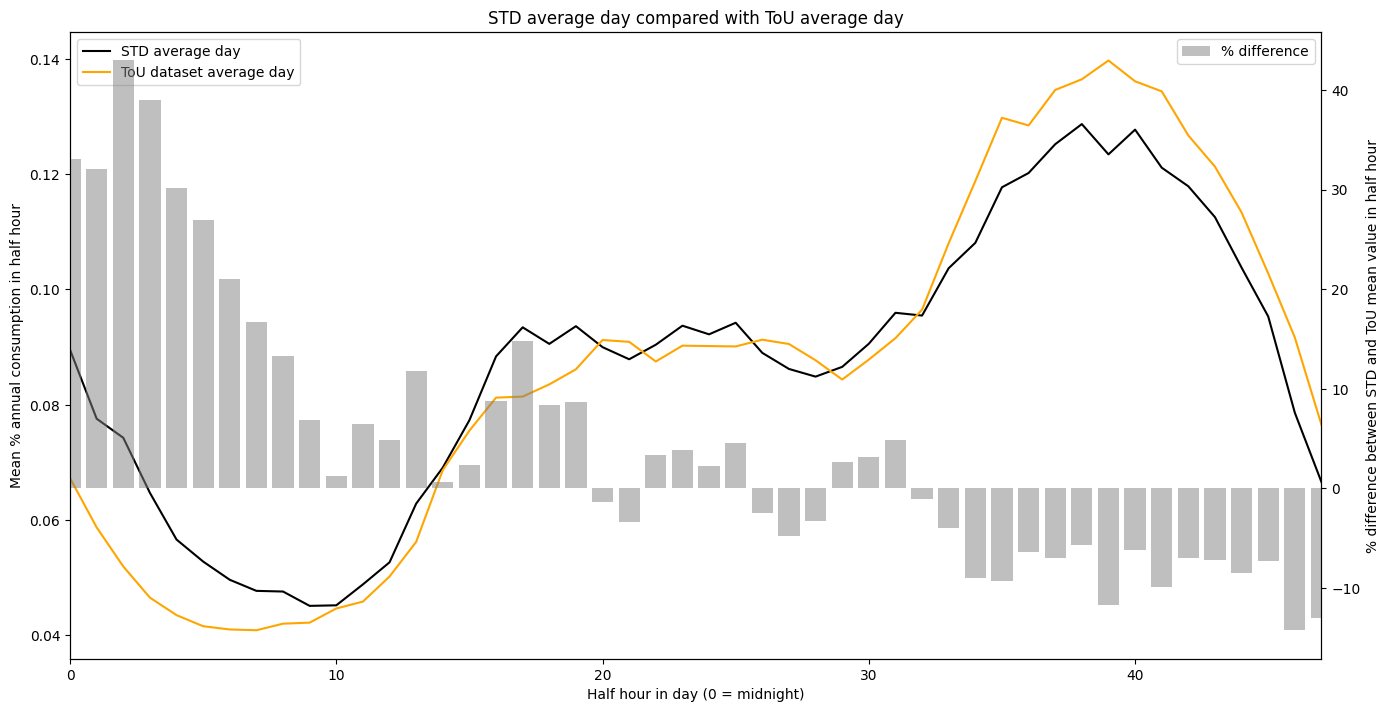

In [378]:
plot_average_day_comparison(std_hh_avg_pivoted_df, tou_hh_avg_pivoted_df)

## **Performing Kmeans Cluster with DTW for STD**

In [393]:
#Perform the PCA
std_pca= perform_pca(std_hh_avg_pivoted_df)

Explained Variance by each component: [4.63815723e-01 2.46661650e-01 5.09529699e-02 4.10515148e-02
 3.48059960e-02 2.17897551e-02 1.63825821e-02 1.59645132e-02
 1.25121875e-02 1.11151744e-02 8.37531077e-03 8.09587477e-03
 6.98394585e-03 5.93054332e-03 5.56077059e-03 5.19546259e-03
 4.52445441e-03 4.02995973e-03 3.74114290e-03 3.59046021e-03
 2.93951646e-03 2.64052848e-03 2.39935919e-03 2.30260131e-03
 1.85755931e-03 1.72308510e-03 1.46077060e-03 1.34840906e-03
 1.28211485e-03 1.17645209e-03 1.08978394e-03 1.05130127e-03
 9.96669715e-04 8.85635663e-04 7.64680963e-04 7.28247904e-04
 6.09207878e-04 5.40445191e-04 4.46249713e-04 4.31238691e-04
 3.91773714e-04 3.61420805e-04 3.28765947e-04 2.57836328e-04
 2.53369657e-04 2.16398027e-04 1.98854074e-04 1.45219716e-04
 9.25128321e-05 9.14715228e-32]
Cumulative Explained Variance: [0.46381572 0.71047737 0.76143034 0.80248186 0.83728785 0.85907761
 0.87546019 0.8914247  0.90393689 0.91505207 0.92342738 0.93152325
 0.9385072  0.94443774 0.94999851

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


211.699 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


158.744 --> 154.905 --> 153.892 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


153.892 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


149.143 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


99.706 --> 95.388 --> 95.388 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


133.962 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


80.884 --> 79.550 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


77.877 --> 77.877 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


83.372 --> 61.514 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


61.514 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


73.269 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


54.665 --> 54.665 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


64.349 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


50.346 --> 49.674 --> 49.674 --> 

[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

62.039 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


46.982 --> 46.183 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


45.853 --> 45.853 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

60.070 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


45.336 --> 44.543

[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s


 --> 44.145 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


44.145 --> 


[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

56.934 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s


43.373 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


42.580 --> 42.183 --> 

[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


42.183 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s


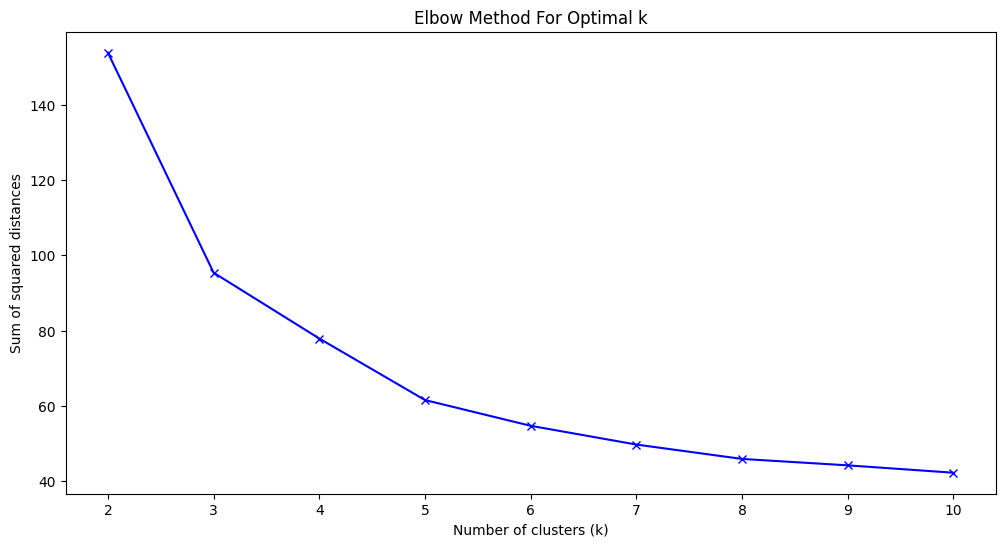

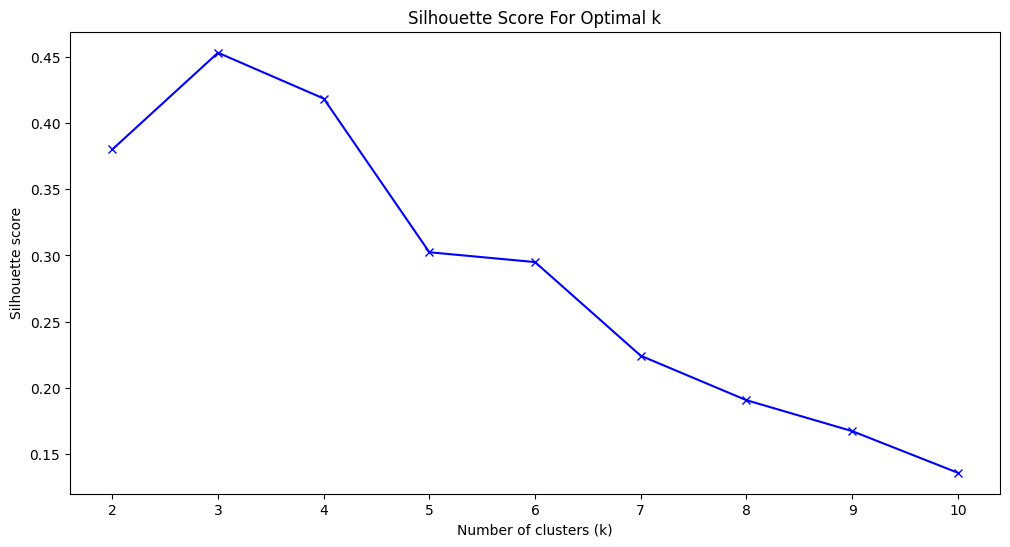

Optimal number of clusters: 3


In [394]:
# Find the Optimal number of Cluster
find_optimal_clusters_pca(std_pca, max_clusters=10)

In [385]:
# Perform Clustering with the optimal number of clusters
std_pca_with_clusters = perform_clustering(std_pca, n_clusters=3)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


149.143 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


99.706 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


95.388 --> 95.388 --> 


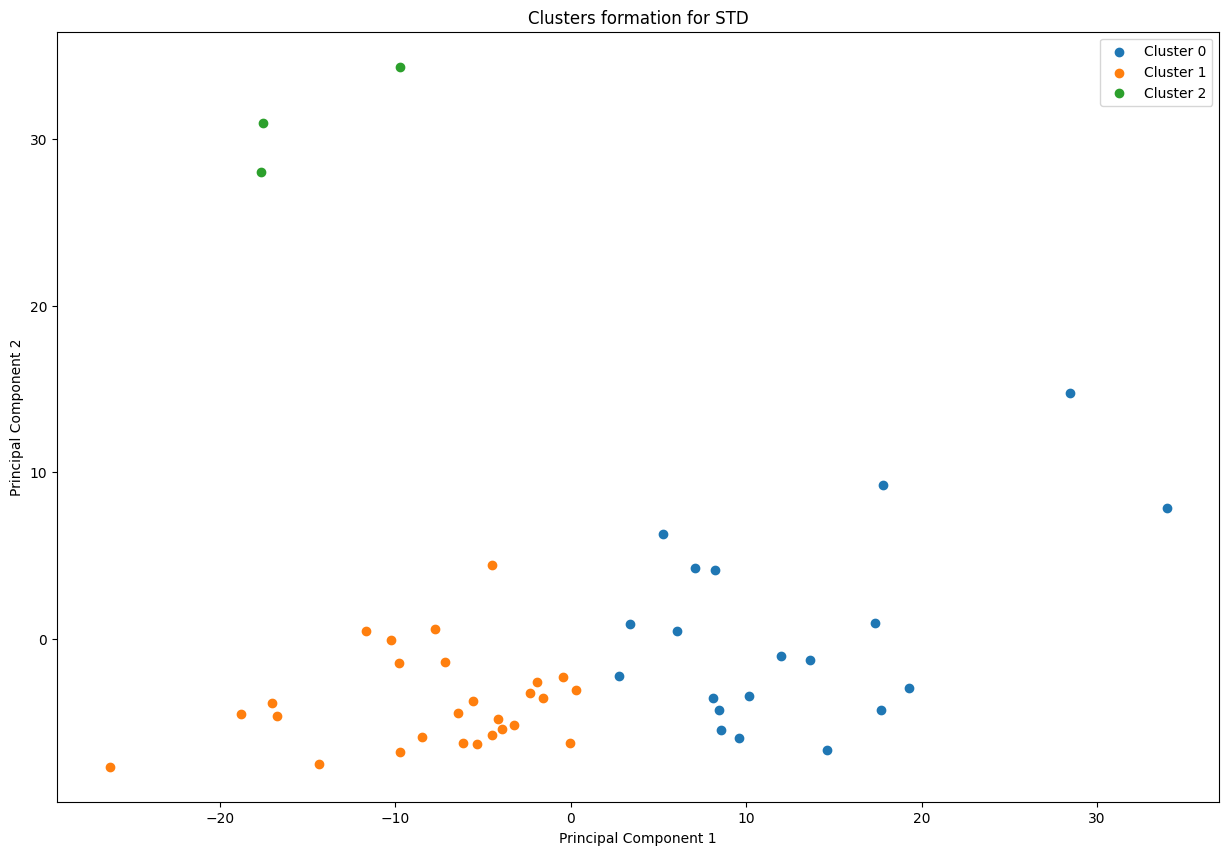

In [387]:
# Plot clusters using the first two PCA components
plot_clusters(std_pca_with_clusters, 'Clusters formation for STD')

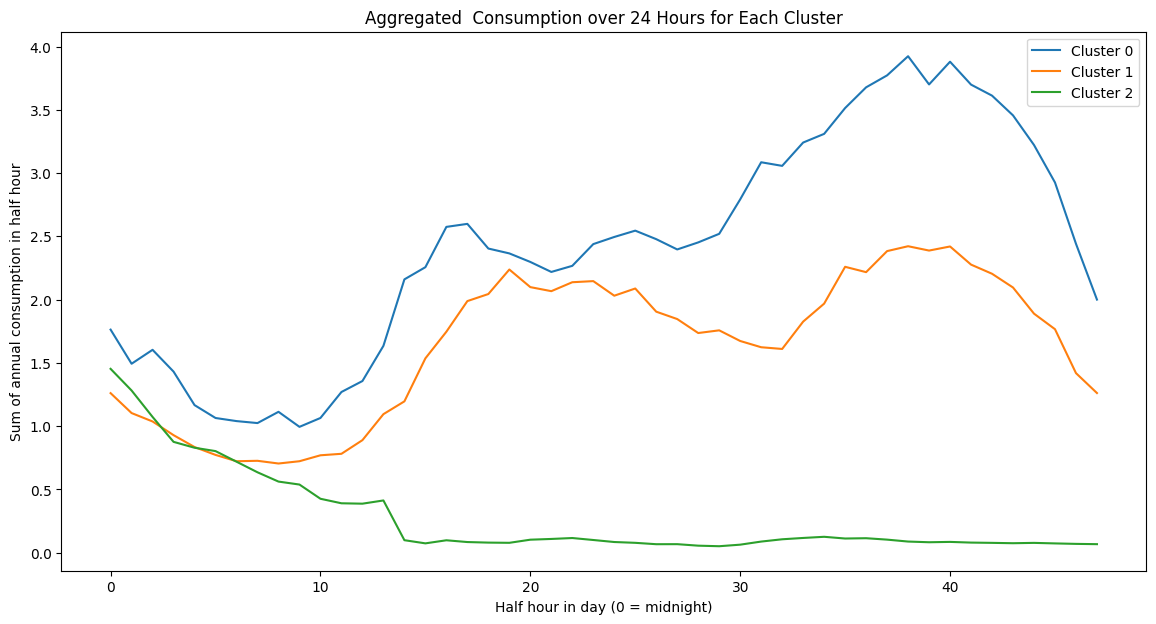

In [391]:
std_hhavg_clusters = std_hh_avg_pivoted_df.copy()
std_hhavg_clusters['Cluster'] = std_pca_with_clusters['Cluster'].values
plot_cluster_daily_consumption(std_hhavg_clusters)

## **Hourly Data for Forecasting**

In [ ]:
# Set 'DateTime' as the index
#std_data_clean.set_index('DateTime', inplace=True)
#tou_data_clean.set_index('DateTime', inplace=True)

#print("Index set successfully")

# Group by 'LCLid' and resample by hour, then aggregate the data
#std_hourly_df = std_data_clean.groupby('LCLid').resample('H').agg({'Consumption': 'sum'}).reset_index()
#tou_hourly_df = tou_data_clean.groupby('LCLid').resample('H').agg({'Consumption': 'sum'}).reset_index()

#print(std_hourly_df)
#print(tou_hourly_df)

In [ ]:
#std_weekly_half_hourly_avg

In [ ]:
#std_hourly_df.to_csv('std_hourly_df.csv')
#tou_hourly_df.to_csv('tou_hourly_df.csv')

In [ ]:
# Pivoting STD Weekly dataframe
#std_pivoted_df = std_hourly_df.pivot(index='LCLid', columns='DateTime', values='Consumption')
#std_pivoted_df.columns.name = None
#std_pivoted_df.reset_index(inplace=True)

In [ ]:
#std_pivoted_df

In [ ]:
# Pivoting ToU Hourly dataframe
#tou_pivoted_df = tou_hourly_df.pivot(index='LCLid', columns='DateTime', values='Consumption')
#tou_pivoted_df.columns.name = None
#tou_pivoted_df.reset_index(inplace=True)

In [ ]:
#tou_pivoted_df